# 数值稳定性和模型初始化

初始化方案的选择在神经网络学习中起着举足轻重的作用，它对保持数值稳定性至关重要。此外，这些初始化方案的选择可以与非线性激活函数的选择有趣的结合在一起。我们选择哪个函数以及如何初始化参数可以决定优化算法收敛的速度有多快。糟糕的选择可能会导致我们在训练时遇到梯度爆炸或梯度消失。

## 1. 梯度消失和梯度爆炸

考虑一个具有$L$层、输入$\mathbf{x}$和输出$\mathbf{o}$的深层网络。
每一层$l$由变换$f_l$定义，
该变换的参数为权重$\mathbf{W}^{(l)}$，
其隐藏变量是$\mathbf{h}^{(l)}$（令 $\mathbf{h}^{(0)} = \mathbf{x}$）。
我们的网络可以表示为：

$$\mathbf{h}^{(l)} = f_l (\mathbf{h}^{(l-1)}) \text{ 因此 } \mathbf{o} = f_L \circ \ldots \circ f_1(\mathbf{x}).$$

如果所有隐藏变量和输入都是向量，
我们可以将$\mathbf{o}$关于任何一组参数$\mathbf{W}^{(l)}$的梯度写为下式：

$$\partial_{\mathbf{W}^{(l)}} \mathbf{o} = \underbrace{\partial_{\mathbf{h}^{(L-1)}} \mathbf{h}^{(L)}}_{ \mathbf{M}^{(L)} \stackrel{\mathrm{def}}{=}} \cdot \ldots \cdot \underbrace{\partial_{\mathbf{h}^{(l)}} \mathbf{h}^{(l+1)}}_{ \mathbf{M}^{(l+1)} \stackrel{\mathrm{def}}{=}} \underbrace{\partial_{\mathbf{W}^{(l)}} \mathbf{h}^{(l)}}_{ \mathbf{v}^{(l)} \stackrel{\mathrm{def}}{=}}.$$

换言之，该梯度是$L-l$个矩阵
$\mathbf{M}^{(L)} \cdot \ldots \cdot \mathbf{M}^{(l+1)}$
与梯度向量 $\mathbf{v}^{(l)}$的乘积。
因此，我们容易受到数值下溢问题的影响.
当将太多的概率乘在一起时，这些问题经常会出现。
在处理概率时，一个常见的技巧是切换到对数空间，
即将数值表示的压力从尾数转移到指数。
不幸的是，上面的问题更为严重：
最初，矩阵 $\mathbf{M}^{(l)}$ 可能具有各种各样的特征值。
他们可能很小，也可能很大；
他们的乘积可能非常大，也可能非常小。

不稳定梯度带来的风险不止在于数值表示；
不稳定梯度也威胁到我们优化算法的稳定性。
我们可能面临一些问题。
要么是**梯度爆炸**（gradient exploding）问题：
参数更新过大，破坏了模型的稳定收敛；
要么是**梯度消失**（gradient vanishing）问题：
参数更新过小，在每次更新时几乎不会移动，导致模型无法学习。

### 1.1 梯度消失

曾经sigmoid函数 $1/(1 + \exp(-x))$ 很流行，
因为它类似于阈值函数。
由于早期的人工神经网络受到生物神经网络的启发，
神经元要么完全激活要么完全不激活（就像生物神经元）的想法很有吸引力。
然而，它却是导致梯度消失问题的一个常见的原因，
让我们仔细看看sigmoid函数为什么会导致梯度消失：

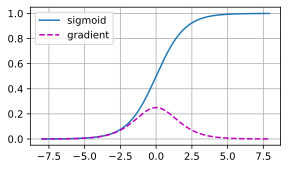

In [4]:
%matplotlib inline
import torch
from d2l import torch as d2l

x = torch.arange(-8.0, 8.0, 0.1, requires_grad=True)
y = torch.sigmoid(x)
y.sum().backward()

d2l.plot(x.detach().numpy(), [y.detach().numpy(), x.grad.numpy()], legend=['sigmoid', 'gradient'], figsize=(4.5, 2.5))

正如上图，当sigmoid函数的输入很大或是很小时，它的梯度都会消失。
此外，当反向传播通过许多层时，除非我们在刚刚好的地方，
这些地方sigmoid函数的输入接近于零，否则整个乘积的梯度可能会消失。
当我们的网络有很多层时，除非我们很小心，否则在某一层可能会切断梯度。
事实上，这个问题曾经困扰着深度网络的训练。
因此，更稳定的ReLU系列函数已经成为从业者的默认选择（虽然在神经科学的角度看起来不太合理）。

### 1.2 梯度爆炸

相反，梯度爆炸可能同样令人烦恼。
为了更好地说明这一点，我们生成100个高斯随机矩阵，并将它们与某个初始矩阵相乘。
对于我们选择的尺度（方差$\sigma^2=1$），矩阵乘积发生爆炸。
当这种情况是由于深度网络的初始化所导致时，我们没有机会让梯度下降优化器收敛。

In [5]:
M = torch.normal(0, 1, size=(4, 4))
print(f'初始矩阵：\n{M}')

for i in range(100):
    M = torch.mm(M, torch.normal(0, 1, size=(4, 4)))
print(f'乘以100个矩阵后：\n{M}')

初始矩阵：
tensor([[ 0.1296,  0.6150, -1.5895,  0.3750],
        [-1.3450, -1.0929,  0.9115, -0.1023],
        [ 0.5728,  0.0647,  1.3536,  1.2879],
        [-0.5599, -1.1085, -0.5417, -1.1157]])
乘以100个矩阵后：
tensor([[ 2.7947e+24,  1.1966e+24,  2.3186e+23, -1.0762e+24],
        [-1.5045e+23, -6.4416e+22, -1.2482e+22,  5.7936e+22],
        [-1.0220e+25, -4.3757e+24, -8.4788e+23,  3.9355e+24],
        [ 8.9403e+24,  3.8279e+24,  7.4173e+23, -3.4428e+24]])


### 1.3. 打破对称性

神经网络设计中的另一个问题是其**参数化所固有的对称性**。
假设我们有一个简单的多层感知机，它有一个隐藏层和两个隐藏单元。
在这种情况下，我们可以对第一层的权重$\mathbf{W}^{(1)}$进行重排列，
并且同样对输出层的权重进行重排列，可以获得相同的函数。
第一个隐藏单元与第二个隐藏单元没有什么特别的区别。
换句话说，我们在每一层的隐藏单元之间具有排列对称性。

假设输出层将上述两个隐藏单元的多层感知机转换为仅一个输出单元。
想象一下，如果我们将隐藏层的所有参数初始化为$\mathbf{W}^{(1)} = c$，
$c$为常量，会发生什么？
在这种情况下，在前向传播期间，两个隐藏单元采用相同的输入和参数，
产生相同的激活，该激活被送到输出单元。
在反向传播期间，根据参数$\mathbf{W}^{(1)}$对输出单元进行微分，
得到一个梯度，其元素都取相同的值。
因此，在基于梯度的迭代（例如，小批量随机梯度下降）之后，
$\mathbf{W}^{(1)}$的所有元素仍然采用相同的值。
这样的迭代永远不会打破对称性，我们可能永远也无法实现网络的表达能力。
隐藏层的行为就**好像只有一个单元**。
请注意，虽然小批量随机梯度下降不会打破这种对称性，但**暂退法正则化**可以。

In [98]:
from d2l import torch as d2l
from torch import nn

true_w = torch.tensor([2, -3.4])
true_b = 4.2
data_iter = d2l.load_array(d2l.synthetic_data(true_w, true_b, 1000), batch_size=10)
net = nn.Sequential(nn.Linear(2, 2), nn.ReLU(), nn.Linear(2, 1))
loss = nn.MSELoss()
trainer = torch.optim.SGD(net.parameters(), lr=0.03)

def train():
    animator = d2l.Animator(xlabel='batch', ylabel='value',
                               xlim=[1, 100], legend=['w1', 'w2', 'g1', 'g2'],
                               figsize=(10, 3))
    w = []
    batch = 0
    for X, y in data_iter:
        batch += 1
        l = loss(net(X), y)  # net本身自带了weight和bias
        trainer.zero_grad()  # 清零梯度
        l.backward()
        animator.add(batch, (net[2].weight.data[0][0], net[2].weight.data[0][1], 
                             net[2].weight.grad[0][0], net[2].weight.grad[0][1]))
        w.append(f'net[2].weight.data: ({net[2].weight.data[0][0]},{net[2].weight.data[0][1]}), net[2].weight.grad: ({net[2].weight.grad[0][0]},{net[2].weight.grad[0][1]})')
        trainer.step()
    return w

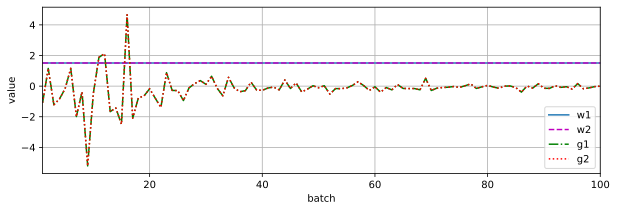

In [95]:
net[0].weight.data.fill_(1)
net[0].bias.data.fill_(0)
net[2].weight.data.fill_(1)
net[2].bias.data.fill_(0)
info = train()

In [97]:
for i in info:
    print(i)

net[2].weight.data: (1.0,1.0), net[2].weight.grad: (-1.0872706174850464,-1.0872706174850464)
net[2].weight.data: (1.0326181650161743,1.0326181650161743), net[2].weight.grad: (1.154828667640686,1.154828667640686)
net[2].weight.data: (0.9979733228683472,0.9979733228683472), net[2].weight.grad: (-1.2168629169464111,-1.2168629169464111)
net[2].weight.data: (1.0344792604446411,1.0344792604446411), net[2].weight.grad: (-0.8348892331123352,-0.8348892331123352)
net[2].weight.data: (1.059525966644287,1.059525966644287), net[2].weight.grad: (-0.16675162315368652,-0.16675162315368652)
net[2].weight.data: (1.064528465270996,1.064528465270996), net[2].weight.grad: (1.1623926162719727,1.1623926162719727)
net[2].weight.data: (1.0296566486358643,1.0296566486358643), net[2].weight.grad: (-1.9866706132888794,-1.9866706132888794)
net[2].weight.data: (1.089256763458252,1.089256763458252), net[2].weight.grad: (-0.37558597326278687,-0.37558597326278687)
net[2].weight.data: (1.1005243062973022,1.100524306297

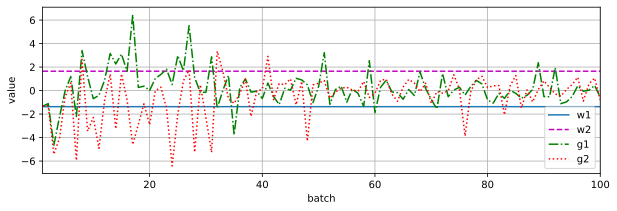

In [99]:
net[0].weight.data.fill_(1)
net[0].bias.data.fill_(0)
info = train()

In [100]:
for i in info:
    print(i)

net[2].weight.data: (-0.5506134033203125,0.03704160451889038), net[2].weight.grad: (-1.3372552394866943,-1.3372552394866943)
net[2].weight.data: (-0.5104957222938538,0.07715925574302673), net[2].weight.grad: (-1.1106619834899902,-1.2861385345458984)
net[2].weight.data: (-0.47717586159706116,0.11574341356754303), net[2].weight.grad: (-4.647372722625732,-5.422460556030273)
net[2].weight.data: (-0.33775466680526733,0.2784172296524048), net[2].weight.grad: (-2.2440571784973145,-4.049088001251221)
net[2].weight.data: (-0.2704329490661621,0.39988985657691956), net[2].weight.grad: (-0.013594272546470165,-0.5239877104759216)
net[2].weight.data: (-0.2700251340866089,0.4156094789505005), net[2].weight.grad: (1.1905732154846191,0.6387297511100769)
net[2].weight.data: (-0.3057423233985901,0.3964475989341736), net[2].weight.grad: (-2.201864242553711,-5.944749355316162)
net[2].weight.data: (-0.23968639969825745,0.5747900605201721), net[2].weight.grad: (3.4042718410491943,2.6546812057495117)
net[2].w

https://zhuanlan.zhihu.com/p/75879624



## 2. 参数初始化

解决（或至少减轻）上述问题的一种方法是进行**参数初始化**，
优化期间的注意和适当的**正则化**也可以进一步提高稳定性。

### 2.1 默认初始化

在前面的部分中，我们使用**正态分布**来初始化权重值。
如果我们不指定初始化方法，框架将使用默认的随机初始化方法，对于中等难度的问题，这种方法通常很有效。

### 2.2 Xavier初始化

让我们看看某些**没有非线性**的全连接层输出（例如，隐藏变量）$o_{i}$的尺度分布。
对于该层$n_\mathrm{in}$输入$x_j$及其相关权重$w_{ij}$，输出由下式给出

$$o_{i} = \sum_{j=1}^{n_\mathrm{in}} w_{ij} x_j.$$

权重$w_{ij}$都是从同一分布中独立抽取的。
此外，让我们假设该分布具有零均值和方差$\sigma^2$。
请注意，这并不意味着分布必须是高斯的，只是均值和方差需要存在。
现在，让我们假设层$x_j$的输入也具有零均值和方差$\gamma^2$，
并且它们独立于$w_{ij}$并且彼此独立。
在这种情况下，我们可以按如下方式计算$o_i$的平均值和方差：

$$
\begin{aligned}
    E[o_i] & = \sum_{j=1}^{n_\mathrm{in}} E[w_{ij} x_j] \\&= \sum_{j=1}^{n_\mathrm{in}} E[w_{ij}] E[x_j] \\&= 0, \\
    \mathrm{Var}[o_i] & = E[o_i^2] - (E[o_i])^2 \\
        & = \sum_{j=1}^{n_\mathrm{in}} E[w^2_{ij} x^2_j] - 0 \\
        & = \sum_{j=1}^{n_\mathrm{in}} E[w^2_{ij}] E[x^2_j] \\
        & = n_\mathrm{in} \sigma^2 \gamma^2.
\end{aligned}
$$

保持方差不变的一种方法是设置$n_\mathrm{in} \sigma^2 = 1$。
现在考虑反向传播过程，我们面临着类似的问题，尽管梯度是从更靠近输出的层传播的。
使用与前向传播相同的推断，我们可以看到，除非$n_\mathrm{out} \sigma^2 = 1$，
否则梯度的方差可能会增大，其中$n_\mathrm{out}$是该层的输出的数量。
这使得我们进退两难：我们不可能同时满足这两个条件。
相反，我们只需满足：

$$
\begin{aligned}
\frac{1}{2} (n_\mathrm{in} + n_\mathrm{out}) \sigma^2 = 1 \text{ 或等价于 }
\sigma = \sqrt{\frac{2}{n_\mathrm{in} + n_\mathrm{out}}}.
\end{aligned}
$$

这就是现在标准且实用的**Xavier初始化**的基础。
通常，Xavier初始化从均值为零，方差
$\sigma^2 = \frac{2}{n_\mathrm{in} + n_\mathrm{out}}$
的高斯分布中采样权重。
我们也可以将其改为选择从均匀分布中抽取权重时的方差。
注意均匀分布$U(-a, a)$的方差为$\frac{a^2}{3}$。
将$\frac{a^2}{3}$代入到$\sigma^2$的条件中，将得到初始化值域：

$$U\left(-\sqrt{\frac{6}{n_\mathrm{in} + n_\mathrm{out}}}, \sqrt{\frac{6}{n_\mathrm{in} + n_\mathrm{out}}}\right).$$

尽管在上述数学推理中，“不存在非线性”的假设在神经网络中很容易被违反，
但Xavier初始化方法在实践中被证明是有效的。

## 3. 小结

* 梯度消失和梯度爆炸是深度网络中常见的问题。在参数初始化时需要非常小心，以确保梯度和参数可以得到很好的控制。
* 需要用启发式的初始化方法来确保初始梯度既不太大也不太小。
* ReLU激活函数缓解了梯度消失问题，这样可以加速收敛。
* 随机初始化是保证在进行优化前打破对称性的关键。
* Xavier初始化表明，对于每一层，输出的方差不受输入数量的影响，任何梯度的方差不受输出数量的影响。